<p> Run a simulation of filling in a network based on Aurelli et al. (2015) </p>
<p>**(.inp and .config files already written)**</p>
<p> This notebook:</p>
<ul>
<li>Uses a .inp file with several short pipes to interpolate a sudden angle change </li>
<li>Runs a simumlation of Aureelli et al.'s setup</li>
<li>Saves the results to compare with the paper data</li>
</ul>
<p> Anna's original code tracks pipe height/pressure w.r.t. the base of the pipe. </p>
<p> Xin's modification adds the base elevation to the pipe bottom so that results are visualized physically.</p>

In [1]:
from __future__ import division
import sys
sys.path.append("..")

from allthethings import PyNetwork, PyPipe_ps
from allthethings import PyBC_opt_dh
import numpy as np
import matplotlib.pyplot as plt
#%pylab inline
%pylab notebook
from writeit import *
import pickle
import time
fi = "../indata/Xindata/PaperCali_SmoothCurve-2.0.inp"
fc = "../indata/Xindata/PaperCali_SmoothCurve-2.0.config"
mtype = 1                          
n1 = PyNetwork(fi,fc,mtype)

Populating the interactive namespace from numpy and matplotlib


In [2]:
mdx = min([n1.Ls[i]/n1.Ns[i] for i in range(n1.Nedges)])
dt = n1.T/n1.M
#print timing information
print "pressure wave speed is %.1f m/s"% (max(n1.a))
print "Courant number (pressure wave) = 1/(dx/dt)*(wave speed) = %.2f; must be <1" % (max(n1.a)*dt/mdx)


pressure wave speed is 12.0 m/s
Courant number (pressure wave) = 1/(dx/dt)*(wave speed) = 0.75; must be <1


In [3]:
#################   Get Elevation from Input File ###################
def getElev(fi):
    #DT: This function creates an array of junction elevations from the INP file; 
    #DT: why is this necessary; we already have slope data from .inp ?
    elev = []
    f = open(fi, 'r')
    Bool = False
    for line in f:
        label = 0
        line = line.split()
        if line and line[0]== "[PIPES]":
            return elev
        if Bool and line:
            elev.append(float(line[1]))
        if line and line[0] == ";ID":
            Bool = True

###################### Function used to calculate target A given a common depth h #############    
def recursefind(pipe, low, low_error, high, high_error, H):
    A_base = 1e-4
    mid = (low+high)/2
    mid_error = pipe.pbar(mid, False) - H
    if (abs(mid_error) < A_base):
        return mid
    if (low_error*mid_error<0):
        return recursefind(pipe, low, low_error, mid, mid_error, H)
    if (high_error*mid_error<0):
        return recursefind(pipe, mid, mid_error, high, high_error, H)
    print "There must be something wrong"

# H is the target pressure head
# i is the pipe number
# Pipe is PyPipe_ps object
def Aofpbar(pipe, H, i):
    A_base = 1e-4
    if (H > pipe.pbar(pipe.At,False)):
        result = (n1.Ds[i]/2-pipe.At/pipe.Ts)/(4.*H/3.1415926/pow(n1.Ds[i],2)-1/pipe.Ts)
    else:
        if (H <pipe.pbar(A_base, False)):
            return A_base
        if (abs(pipe.pbar(pipe.At, False)-H)<pipe.pbar(A_base, False)):
            return pipe.At
        result = recursefind(pipe, 0, -H, pipe.At, pipe.pbar(pipe.At, False)-H, H)
    return result

##### Given a target pressure head H, set IC for a certain pipe i, using recursion to find #######
def SetPipeIC (n1, i, H, left, right):
    L = n1.Ls[i]
    N = n1.Ns[i]
    D = n1.Ds[i]
    dx = L/N
    diff = (right-left)/N
    pipe = PyPipe_ps(N,D,L,n1.M,n1.a[0])
    A = []
    A_crt = 1e-4
    Q_crt = 1e-10
    for k in xrange(N):
        current = left + (k+1/2)*diff
        deltaH = H - current            # DeltaH is pressure head we want
        if deltaH <= pipe.pbar(A_crt, False):
            A_current = A_crt
        else:
            A_current = Aofpbar(pipe, deltaH, i)     
        A.append(A_current)
        #print pipe.pbar(A_current, False) + current
    Q = Q_crt*np.ones(N)
    n1.setIC(i, A, Q)


############ Inflpow Boundary Values (m^3/s) #########################
q0 = 0   #inflow boundary value (m^3/s), used to create the Q0 vector
#DT: why not set this as reflective BC?
######################################################################
M = n1.M  
T = n1.T   
Q0 = q0*np.ones(M+1)          
n1.setbVal(0,Q0)   #boundary condition for junction 0 (at the left end of pipe 0)
print 'Inflow boundary finished'

########################## Set IC for all pipes #################################
elev = getElev(fi)
print 'Elevtaion Got'
p0 = PyPipe_ps(n1.Ns[0], n1.Ds[0],n1.Ls[0], M, n1.a[0])


bench_H = 0.504 + p0.pbar(p0.AofH(0.225, False), False) #### Initial Water Depth = 0.225m @ G1

#bench_H = 0.504 + 0.225     #### Initial Pressure Head = 0.225m @ G1



# First pipe (wet)
pipe = 0
edge = n1.conn[pipe]
SetPipeIC(n1, pipe, bench_H, elev[edge[0]], elev[edge[1]])

# Other two pipes (dry)
A_crt = 1e-4
Q_crt = 1e-10
for pipe in xrange(1,7):
    Ni = n1.Ns[pipe]
    n1.setIC(pipe, A_crt*np.ones(Ni), Q_crt*np.ones(Ni))

print 'IC completed'

Inflow boundary finished
Elevtaion Got
IC completed


In [4]:
n1.showLayout()


   pipe | start node | end node  | slope 
-----------------------------------
     0  |  0         | 1         | 0.083665
     1  |  1         | 2         | 0.084011
     2  |  2         | 3         | 0.047600
     3  |  3         | 4         | 0.020000
     4  |  4         | 5         | -0.050000
     5  |  5         | 6         | -0.120000
     6  |  6         | 7         | -0.267680


   node | #incoming pipes
-------------------------
  0     |  1
  1     |  2
  2     |  2
  3     |  2
  4     |  2
  5     |  2
  6     |  2
  7     |  1


For full pipe, H= 0.0960033703351


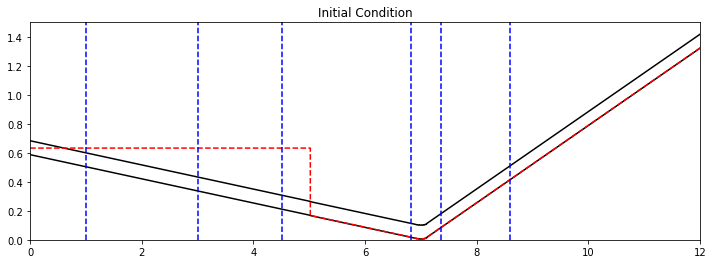

In [5]:
#########  Plot IC ####

pipe_interest=range(0,7)
Gauge_loc =[1.00,
        3.01,
        4.52,
        6.82,
        7.36,
        8.60 ]
x_interest=[]
pipe_length=0
for j in pipe_interest: 
    x = np.linspace(pipe_length,pipe_length+n1.Ls[j],n1.Ns[j])
    x_interest.append(x)
    pipe_length=pipe_length+n1.Ls[j]
x_interest_combine = np.concatenate(x_interest,axis =0)


H_interest_tfixed = []
H_elev = []
H_full_pipe = []
p0 = PyPipe_ps(n1.Ns[0], n1.Ds[0],n1.Ls[0], M, n1.a[0])
A_pipe = n1.Ds[0]**2*np.pi/4
Hf = p0.pbar(A_pipe, False)
print "For full pipe, H=",Hf
for i in xrange(len(n1.conn)):  
    #this returns H as a function of x in pipe j at time step m
    Hx = n1.pressureSpaceSeries(i,0) 
    #print Hx
    # Add elevation to the pressure head
    # nd.array can add list to get a new array like matrix sum
    edge = n1.conn[i]
    left = elev[edge[0]]
    right = elev[edge[1]]
    diff = right - left
    Nj = n1.Ns[i]
    He = [left + diff/Nj*(j+0.5)  for j in xrange(Nj)]
    H_elev.append(He)
    Hf_pipe = Hf*np.ones(len(He)) + He
    H_full_pipe.append(Hf_pipe)
    Hx = Hx + He
    #print Hx
    H_interest_tfixed.append(Hx)

H_interest_combine = np.concatenate(H_interest_tfixed,axis =0)
H_elev_combine = np.concatenate(H_elev,axis =0)
H_full_pipe_combine = np.concatenate(H_full_pipe,axis =0)

plt.figure(figsize = (12,4)) 
plt.ylim(0,1.5)
plt.xlim(0, 12,21)
plt.title('Initial Condition')
plt.plot(x_interest_combine, H_elev_combine,'black', label='')  
plt.plot(x_interest_combine, H_full_pipe_combine,'black', label='') 
plt.plot(x_interest_combine, H_interest_combine,'r--')    
for gauge in Gauge_loc:
    plot([gauge]*100, np.linspace(0,1.5,100),'b--')
  

In [6]:
# i = 0 means A, i=1 means Q
# j means the grid we are currently looking at, 1<=j<=N
# n means time step 
# N means the grid number in this certain pipe
def idx_t(i,j,n,N):
    #DT: this helper function takes care of indexing the qhist file in the network class.
    #qhist(i) yields
    #array of history of states q = (A,Q) in pipe i. Laid out as [q_0, q_1,..q_M]
    #where q_n = [Aleft, A0, A1,,,A_N-1, Aright, Qleft, Q0,...Q_N-1,Qright] at time step n
    return (2*(N+2)*n+(N+2)*i+j)

import time
V0 = n1.getTotalVolume()
dt = n1.T/float(n1.M)
dx = n1.Ls/[float(nn) for nn in n1.Ns]
t0 = time.clock()
n1.runForwardProblem(dt)
tf = time.clock()
Vf = n1.getTotalVolume()
print "Solve time is %.5f s"%(tf-t0)
print "Simulated time is %.5f s"%n1.T
print "change in volume is %e m^3"%(Vf-V0)        

Solve time is 20.93242 s
Simulated time is 30.00000 s
change in volume is -5.190821e-04 m^3


0 0 0.0
1 0 0.0
2 0 0.0
3 1 5.02
4 6 7.1
5 6 7.1


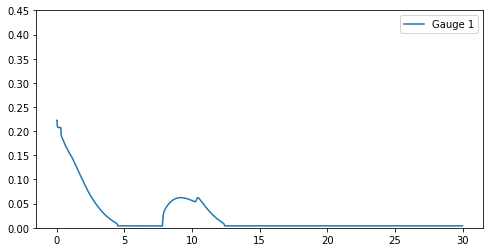

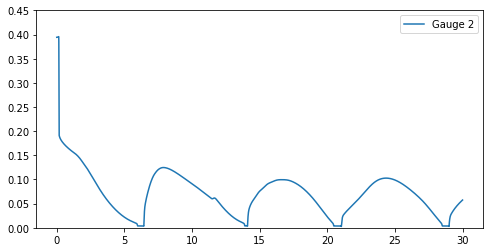

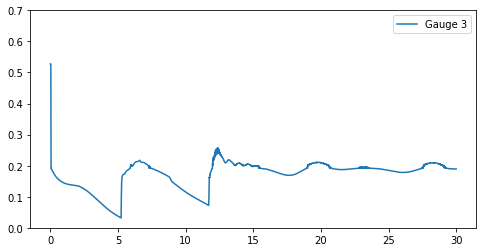

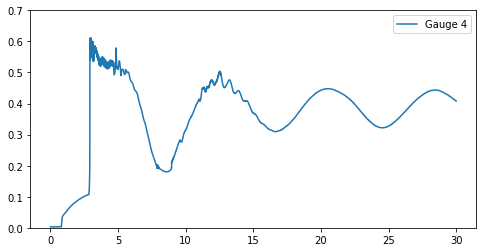

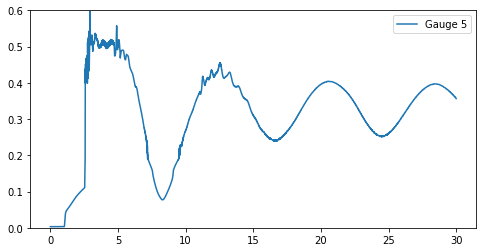

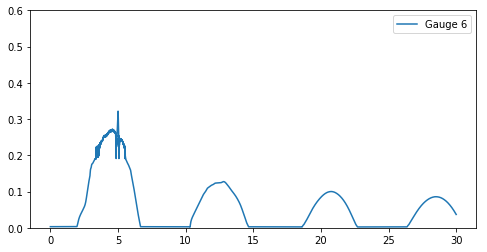

In [7]:
#########  Plot pressure head for all gauges (since @ bottom, so = water depth)

# t is the initial index value that corresponds to P
# P is the pressure that should be averaged over time
# Mi is how many time steps you want to average 
def t_average_time(t, P, Mi):
    # internal variables:
    # -------------------
    # n is the number of times at which a result is desired
    # P_new is a 1xn array of average pressures at said time pts
    # x is the closest integer value of the index corresponding to P_new
    ########################
    if Mi <=1:
        return t, P
    else:
        n = int(len(P[:-1])/Mi)    # Totally M steps in P{:-1], n=M/Mi, n should be an integer
        x = []          
        P_new = []
        for i in xrange(n):
            P_new.append(np.average(P[i*Mi:(i+1)*Mi-1]))
            x.append(t[int((i+0.5)*Mi)])
        return x, P_new

## Get water depth for a single grid along time
def myWaterDepthTime(network_class, pipe_id, grid_id):
    qh = network_class.qhist(pipe_id)
    N = network_class.Ns[pipe_id]
    D = network_class.Ds[pipe_id]
    L = network_class.Ls[pipe_id]
    M = network_class.M
    A = [qh[idx_t(0, grid_id, j, N)] for j in xrange(0,M+1)]
    pipe_class = PyPipe_ps(N, D, L, M, network_class.a[0])
    h = [pipe_class.HofA(i, False) for i in A] # I believe the bool P=False variable is a legacy var and irrelevant.
    return np.array(h)

def myWaterDepthSpace(network_class, pipe_id, time_step):
    qh = network_class.qhist(pipe_id)
    N = network_class.Ns[pipe_id]
    D = network_class.Ds[pipe_id]
    L = network_class.Ls[pipe_id]
    M = network_class.M
    A = [qh[idx_t(0, j, time_step, N)] for j in xrange(1,N+1)]
    pipe_class = PyPipe_ps(N, D, L, M, network_class.a[0])
    h = [pipe_class.HofA(i, False) for i in A] #recall this function finds H, given A. 
    return np.array(h)

t = linspace(0,n1.T, n1.M+1)

min_DisplayTimeStep=0.0001 #max display resolution =10Hz

if dt < min_DisplayTimeStep:
    Mi = int(min_DisplayTimeStep/dt) #overides viewing preference if selected to be more frequent than 1/min_DisplayTimeStep
else:
    Mi = 1 #no averaging

for i in xrange(len(Gauge_loc)):
    
    gauge = Gauge_loc[i]
    if i<3:
        pipe = 0
        pre_len = 0.
        
    if i== 3:
        pipe = 1
        pre_len = n1.Ls[0]
       
    if i>3:
        pipe = 6
        pre_len =  n1.Ls[0]+n1.Ls[1]+n1.Ls[2]+n1.Ls[3]+n1.Ls[4]+n1.Ls[5] 
    print i, pipe, pre_len
    
    
    #Hg = n1.pressureTimeSeries(pipe, int((gauge-pre_len)/n1.Ls[pipe]*n1.Ns[pipe]))  
    
    grid_id_=int((gauge-pre_len)/n1.Ls[pipe]*n1.Ns[pipe]) #approximate grid_id of gauge location
    Hg = myWaterDepthTime(n1, pipe, grid_id_ ) #pressure series at grid_id = location of gauge @Gauge_loc[i]
    
    
    tn, Hgn = t_average_time(t, Hg, Mi) #Averaged time and pressure stamps
    plt.figure(figsize=(8,4))
    if i < 2:
        plt.ylim (0, 0.45)
    elif i<4:
        plt.ylim (0, 0.7)
    else:
        plt.ylim(0, 0.6)
    txt = "Gauge "+str(i+1)
    plt.plot(tn, Hgn, label=txt)
    plt.legend()
    #savefig('/home/xin/pipes/examples/output_data/MyTtest/Paper_calibration/Mn=0.009,a=12/%s Depth_constrc_smooth.png'%txt)


In [8]:


np.shape(n1.qhist(0))

(12097008,)

<IPython.core.display.Javascript object>


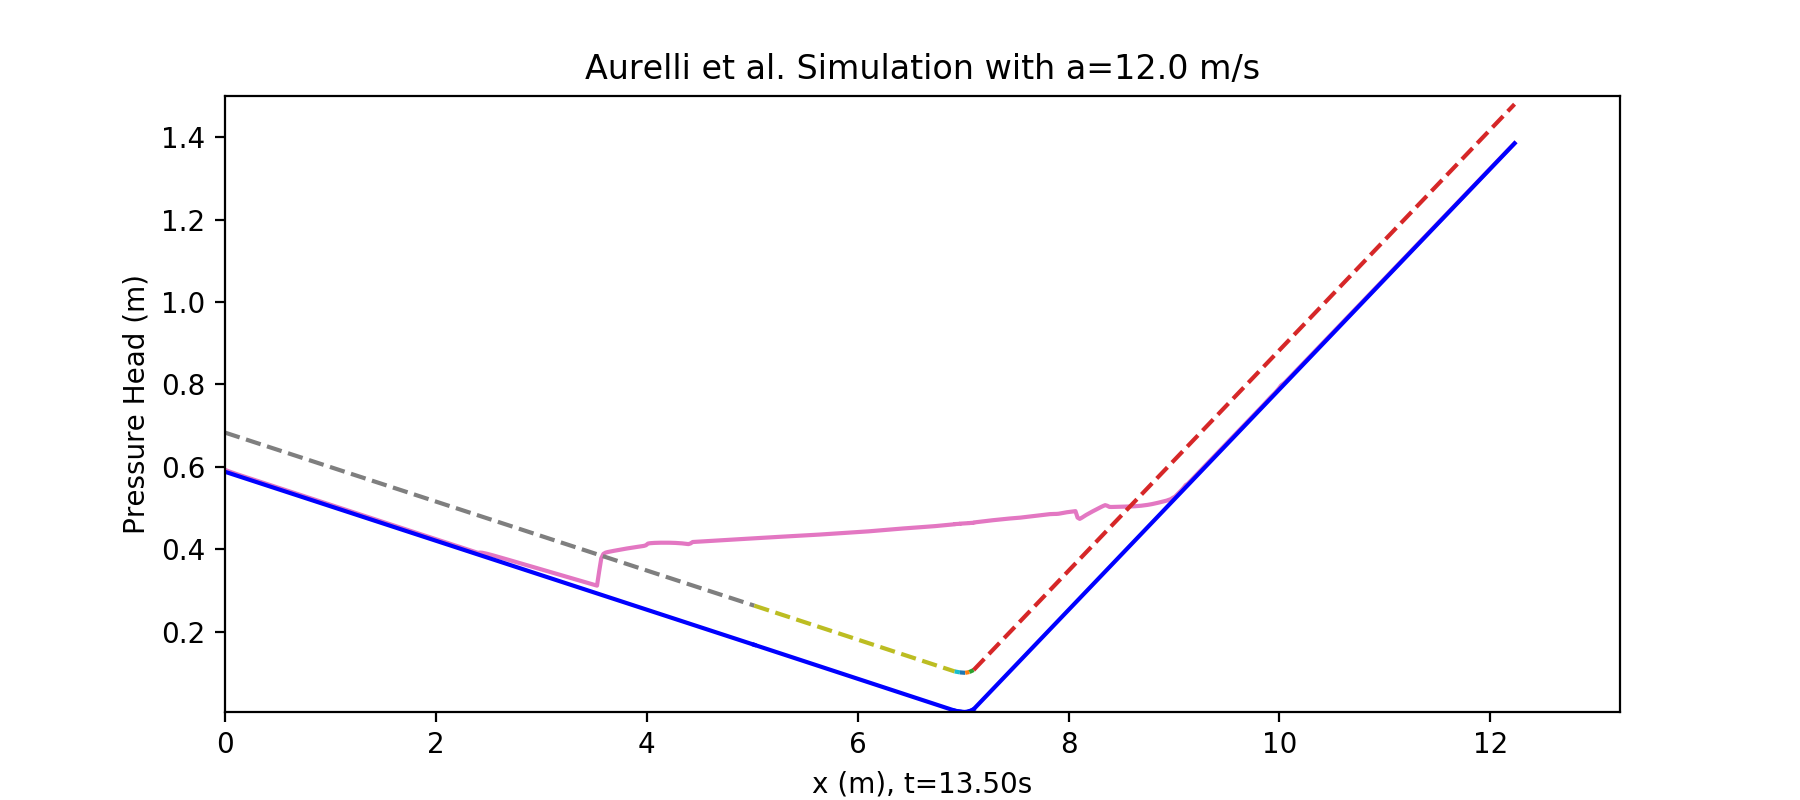

80 0.00125


In [10]:
##### Continuous Animation, Fixed Opening ########

from matplotlib import animation
#from matplotlib import animation, rc
#from IPython.display import HTML, Image


%matplotlib notebook


# Set up formatting for the movie files
Writer = animation.writers['ffmpeg']
writer = Writer(fps=10, metadata=dict(artist='Me'), bitrate=800)
#writer ='imagemagick'

#*********************************************************************************
pipe_interest=range(0,7)
outflow_pipe =[]
orifice = []
dt = n1.T/n1.M
t_delta=0.1             # unit: s
t_start= 0               # unit:s
t_end=n1.T               # unit: s
#*********************************************************************************

# animation already imported above
plt.ion()
plt.show()

# create x axis
x_interest=[]
pipe_length=0
for j in pipe_interest: 
    x = np.linspace(pipe_length,pipe_length+n1.Ls[j],n1.Ns[j])
    x_interest.append(x)
    pipe_length=pipe_length+n1.Ls[j]
x_interest_combine = np.concatenate(x_interest,axis =0)


#create initial figure
fig = plt.figure(figsize= (9,4))
plt.xlim(0,x_interest[-1][-1]+1)
plt.ylim(min(elev), 1.5)
lines = [plt.plot([], [])[0] for i in range(len(pipe_interest))] # number of lines plot on the figure
plt.xlabel('x (m)')        
plt.ylabel('Pressure Head (m)')
plt.title('Aurelli et al. Simulation with a=%.1f m/s'%(n1.a[0]))

pipe_length = 0
## Record the sequence of outflow pipe
out = 0
for pipe in pipe_interest:
    # create x axis
    x = np.linspace(pipe_length,pipe_length+n1.Ls[pipe],n1.Ns[pipe])
    
    # create elevation line
    edge = n1.conn[pipe]
    left = elev[edge[0]]
    right = elev[edge[1]]
    diff = right - left
    He = [left + diff/(len(x)-1)*i  for i in xrange(len(x))]
    plt.plot(x,  He, 'b')
    
    # create pipe full line
    p0 = PyPipe_ps(n1.Ns[pipe], n1.Ds[pipe],n1.Ls[pipe], M, n1.a[0])
    A0 = n1.Ds[pipe]*n1.Ds[pipe]/4*3.14
    H_full = [p0.Eta(A0,True)/9.81/A0]*len(x) 
    H_full = (np.add(H_full, He)).tolist()
    plt.plot(x, H_full,'--',label= 'pipe %d full'%(pipe))
    
    # If pipe is also outflow pipe
    if pipe in outflow_pipe:
        A_open = p0.AofH(rifice[out], False)
        H_open= [p0.pbar(A_open,False)]*len(x)
        print Orifice[out],A_open, H_open[0] 
        H_open =  (np.add(H_open, He)).tolist()
        plt.plot(x,H_open,'r--',label = "pipe %d orifice"%(pipe))
        out += 1
    pipe_length += n1.Ls[pipe]
    
#legend(bbox_to_anchor=(0.9, 1), loc=2, borderaxespad=0.)
# initialization function: plot the background of each frame


def init():
    for line in lines:
        line.set_data([], [])
    return lines

#dt = n1.T/n1.M  #defined above
Mi_draw=int(t_delta/dt)   # difne how many steps to skip
print Mi_draw, dt
M_start=int(t_start/dt)
M_total=int(t_end/dt)
H_interest=[]


# H_interested_fixed = [ [H1], [H2],... [Hn] ], it stores all pipe's pressure info @ certain time
# H_interest = [ [PressureInfo @ time 1], [Pressure info @ time 2],..,[ Pressure Info @ time m]   ]
def animate(index):
    H_interest_tfixed = []
    for i,line in enumerate(lines):  
        ## get pipe j
        j = pipe_interest[i]
        #this returns H as a function of x in pipe j at time step m
        #Hx = n1.pressureSpaceSeries(j,M_start+index*Mi_draw) 
        Hx = myWaterDepthSpace(n1, j, M_start+index*Mi_draw)
        # Add elevation to the pressure head
        # nd.array can add list to get a new array like matrix sum
        edge = n1.conn[j]
        left = elev[edge[0]]
        right = elev[edge[1]]
        diff = right - left
        Nj = n1.Ns[j]
        He = [left + diff/Nj*(i+0.5)  for i in xrange(Nj)]
        Hx = Hx + He
        H_interest_tfixed.append(Hx)
    H_interest.append(H_interest_tfixed)
    H_interest_combine = np.concatenate(H_interest[index],axis =0)
    line.set_data(x_interest_combine,H_interest_combine)
    plt.xlabel('x (m), t=%.2fs'%((M_start+index*Mi_draw)*dt))
                      
    return lines         
    #legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
#https://jakevdp.github.io/blog/2012/08/18/matplotlib-animation-tutorial/
step = int((M_total-M_start)/Mi_draw)
anim = animation.FuncAnimation(fig, animate, init_func=init,frames=step, interval=1, repeat=True, blit=True)


"""Save Anna Result"""
#anim.save('../examples/output_data/MyTtest/Paper_calibration/Mn=0.009,a=12/noSmoothing_DT_fmpeg_a%.0f.mp4'%n1.a[0],writer=writer)

plt.show()


In [ ]:
######  Only For Check, do not need to run #############
'''
A0 = np.zeros(M+1)
n1.setbVal(0,A0)
n1.setbVal(1,A0)
n1.setbVal(2,A0)
'''
M = n1.M
a = n1.a[0]
p0 = PyPipe_ps(n1.Ns[0], n1.Ds[0],n1.Ls[0], M, a)
p6 = PyPipe_ps(n1.Ns[6], n1.Ds[6],n1.Ls[6], M, a)
A0 = p0.AofH(0.8, True)
A6 = p6.AofH(0.625, True)
print p0.HofA(0.02, False)
print p6.HofA(0.00128, False)
#print p0.pbar(A0, False), p6.pbar(A6, False) , p0.HofA(0.290475, True), p0.AofH(0.0729*0.83, True)



In [ ]:
#### Overlap Anmiation ############

#*********************************************************************************
pipe_interest=[0,1,2,5,6]
outflow_pipe =[5,6]
Orifice = [0.0729, 0.0176]
t_delta=0.1              # unit: s
t_start=0              # unit:s
t_end= 300               # unit: s
#*********************************************************************************

# create x axis
x_interest=[]
pipe_length=0
for j in pipe_interest: 
    x = np.linspace(0,n1.Ls[j],n1.Ns[j])
    x_interest.append(x)

#create initial figure
from matplotlib import animation
fig = plt.figure(figsize= (10,5))
plt.xlim(0,x_interest[-1][-1]+1)
plt.ylim(min(elev), 240)
lines = [plt.plot([], [],label='pipe {}'.format(pipe_interest[i]))[0] for i in range(len(pipe_interest))] # number of lines plot on the figure
plt.xlabel('x (m)')        
plt.ylabel('Pressure Head (m)')
plt.title('Pressure Head in pipe %s'%str(pipe_interest)) 

## Record the sequence of outflow pipe
out = 0

for pipe in pipe_interest:
    # create x axis
    x = np.linspace(0, n1.Ls[pipe], n1.Ns[pipe])
    
    # create elevation line
    edge = n1.conn[pipe]
    left = elev[edge[0]]
    right = elev[edge[1]]
    diff = right - left
    He = [left + diff/(len(x)-1)*i  for i in xrange(len(x))]
    plt.plot(x,  He, 'black')
    
    # create pipe full line
    p0 = PyPipe_ps(n1.Ns[pipe], n1.Ds[pipe],n1.Ls[pipe], M, n1.a[0])
    A0 = n1.Ds[pipe]*n1.Ds[pipe]/4*3.14
    H_full = [p0.Eta(A0,True)/9.81/A0]*len(x) 
    H_full = (np.add(H_full, He)).tolist()
    plt.plot(x, H_full,'b--',label= 'pipe %d full'%(pipe))
    
     # If pipe is also outflow pipe
    if pipe in outflow_pipe:
        A_open = p0.AofH(Orifice[out], False)
        H_open= [p0.pbar(A_open,False)]*len(x)
        print Orifice[out],A_open, H_open[0] 
        H_open =  (np.add(H_open, He)).tolist()
        plt.plot(x,H_open,'g--',label = "pipe %d orifice"%(pipe))
        out += 1
    pipe_length += n1.Ls[pipe]
    
legend(bbox_to_anchor=(0.7, 1), loc=2, borderaxespad=0.)
# initialization function: plot the background of each frame


def init():
    for line in lines:
        line.set_data([], [])
    return lines

dt = n1.T/n1.M
Mi_draw=int(t_delta/dt)   # difne how many steps to skip
M_start=int(t_start/dt)
M_total=int(t_end/dt)

abc= n1.pressureSpaceSeries(2,1000)
print type(abc),len(abc)

def animate(index): 
    for i,line in enumerate(lines):             
        j=pipe_interest[i]
        #this returns H as a function of x in pipe j at time step m
        Hx = n1.pressureSpaceSeries(j,M_start+index*Mi_draw)  
        
        edge = n1.conn[j]
        left = elev[edge[0]]
        right = elev[edge[1]]
        diff = right - left
        Nj = n1.Ns[j]
        He = np.array([left + diff/Nj*(n+0.5)  for n in xrange(Nj)])
     
        Hx = Hx + He
        
        line.set_data(x_interest[i],Hx)
        plt.xlabel('x (m), t=%ds'%((M_start+index*Mi_draw)*dt))
        #line.set_label('pipe %d t=%.2f s'%(j,(dt*(M_start+index*Mi_draw))))
                      
    return lines         
    #legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    

step = int((M_total-M_start)/Mi_draw)
anim = animation.FuncAnimation(fig, animate, init_func=init,frames=step, interval=3, blit=True)
plt.legend(bbox_to_anchor=(0.85, 1), loc=2, borderaxespad=0.)
plt.ylim(top=2)
plt.show()
"""Save My Result"""
#anim.save('/home/xin/pipes/examples/output_data/MyTtest/Karney_Improvement/Anna+B_1.11_6_open0.8/D2=0.2/%s %.0f-%.0f s.mp4'%(str(pipe_interest),t_start,t_end))
#anim.save('/home/xin/pipes/examples/output_data/MyTtest/FieldCalibrate/Oct29_Pressure/%s overlap %.0f-%.0f s.mp4'%(str(pipe_interest),t_start,t_end))



#anim = animation.FuncAnimation(fig, animate, init_func=init,frames=3, interval=20, blit=True)
#anim.save("basic_animation.mp4")
#plt.show()
    # time.sleep(0.01)
    # bbox_to_anchor: the bbox that the legend will be anchored, 1.05 means 1.05 times of figure length
    # borderaxespad: the pad between the axes and legend border
# Display the inflow and outflow for each pipe (m^3)  (ALl PIPES IN MODEL)




In [ ]:
#plot network layout
(xs,ys,conns,ls) = getBasicConnectivity(fi)
Np = shape(conns)[0]
plotNetworkLayout(xs,ys,conns,ls,Np)